# Importing all the libraries here 

In [2]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import decomposition
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns

from plotly.offline import init_notebook_mode, iplot
import matplotlib.pyplot as plt
import plotly.graph_objs as go

from sklearn.decomposition import TruncatedSVD, FastICA, NMF, FactorAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression

from sklearn.manifold import TSNE

from sklearn.decomposition import KernelPCA, PCA



# Importing all the Datasets
#### These are the imputed datasets

In [3]:
df_train = pd.read_csv("ProcessedWeatherData_v5.csv")
df_test = pd.read_csv("ProcessedWeatherDataTest_v5.csv")
df_train.head()
df_train.shape

(87983, 11)

##### Correlation of the Dataset is checked to see what features are relevant

In [4]:
df_train.corr()

,AtmosphericPressure,WindDirection,WindSpeed,Gust,WaveHeight,WavePeriod,AirTemperature,DewPoint,SeaTemperature,RelativeHumidity
AtmosphericPressure,1.000000,-0.076168,-0.388719,-0.420284,-0.429898,-0.250961,0.018300,-0.020685,-0.013369,-0.064759
WindDirection,-0.076168,1.000000,0.117028,0.139023,0.190930,0.133636,0.099881,0.036790,0.137088,-0.070592
WindSpeed,-0.388719,0.117028,1.000000,0.957870,0.631274,0.207663,-0.031589,0.013113,-0.082022,0.065650
Gust,-0.420284,0.139023,0.957870,1.000000,0.715752,0.305819,-0.089816,-0.047670,-0.106682,0.023505
WaveHeight,-0.429898,0.190930,0.631274,0.715752,1.000000,0.802946,-0.168678,-0.170746,-0.174221,-0.113491
WavePeriod,-0.250961,0.133636,0.207663,0.305819,0.802946,1.000000,-0.166358,-0.193637,-0.166830,-0.159426
AirTemperature,0.018300,0.099881,-0.031589,-0.089816,-0.168678,-0.166358,1.000000,0.900933,0.867535,0.431830
DewPoint,-0.020685,0.036790,0.013113,-0.047670,-0.170746,-0.193637,0.900933,1.000000,0.695651,0.779350
SeaTemperature,-0.013369,0.137088,-0.082022,-0.106682,-0.174221,-0.166830,0.867535,0.695651,1.000000,0.193094
RelativeHumidity,-0.064759,-0.070592,0.065650,0.023505,-0.113491,-0.159426,0.431830,0.779350,0.193094,1.000000


##### Drop all the Features that are not going to be used.
##### Since we are dealing with Feature Set 3 (AirTemperatue, DewPoint, SeaTemperature and Realitive Humidity are Kept)

In [5]:
df_train.drop(["station_id","WindDirection","Gust","WaveHeight", "WaveHeight","WavePeriod","AtmosphericPressure","WindSpeed"],inplace = True, axis = 1)
df_test.drop(["station_id","WindDirection","Gust","WaveHeight", "WaveHeight","WavePeriod", "AtmosphericPressure","WindSpeed"],inplace = True, axis = 1)
df_train.head()

,AirTemperature,DewPoint,SeaTemperature,RelativeHumidity
0,16.2,13.9,16.1,86.0
1,13.9,11.0,14.9,83.0
2,7.7,4.0,10.2,77.0
3,14.7,14.0,15.6,96.0
4,13.6,10.7,13.9,83.0


### Here we display the Target Variable vs the features selected 

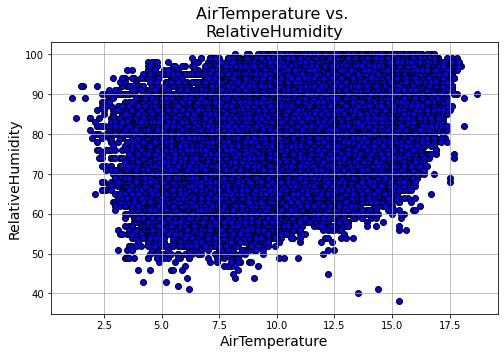

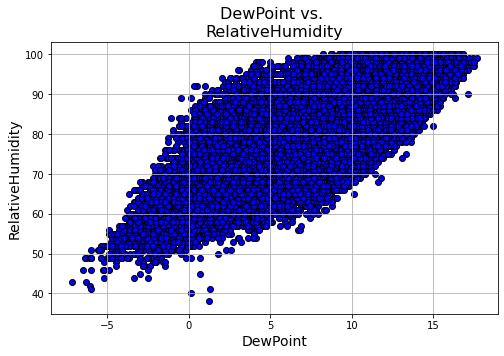

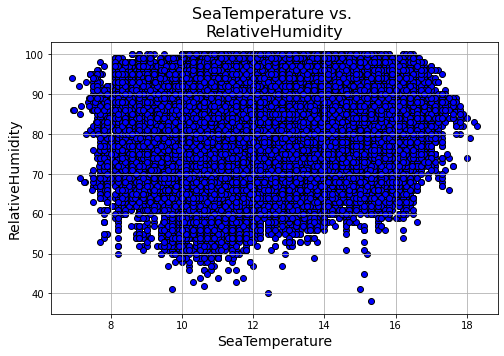

In [6]:
for c in df_train.columns[:-1]:
    plt.figure(figsize=(8,5))
    plt.title("{} vs. \nRelativeHumidity".format(c),fontsize=16)
    plt.scatter(x=df_train[c],y=df_train['RelativeHumidity'],color='blue',edgecolor='k')
    plt.grid(True)
    plt.xlabel(c,fontsize=14)
    plt.ylabel('RelativeHumidity',fontsize=14)
    plt.show()

#### Here a Custom Scaler is used that was developed with other iterations of the data set 
#### specifially for fitting the target variable and the Xtrain separately and for Data Extraction methods which were PCA,ICA

In [7]:
X_train_unscaled = df_train.iloc[:,: -1].values
y_train_unscaled = df_train.iloc[:, -1].values
X_test_unscaled = df_test.iloc[:, :-1].values
y_test_unscaled = df_test.iloc[:, -1].values
print(X_train_unscaled.shape)

class CustomScaler():
    
        def __init__(self, X_Scale, y_Scale ) :
        
            self.X_Scale =   X_Scale 
            self.y_Scale =   y_Scale
            
            self.x_num =     [np.mean(self.X_Scale[:,i]) for i in range(self.X_Scale.shape[1])]
            self.x_maxs =    [np.max(self.X_Scale[:,i]) for i in range(self.X_Scale.shape[1])]
            self.x_mins =    [np.min(self.X_Scale[:,i]) for i in range(self.X_Scale.shape[1])]
            
            self.y_num =     np.mean(self.y_Scale)
            self.y_max_min = np.max(self.y_Scale) - np.min(self.y_Scale)

        def scaleX(self, x_value):
            x = x_value.copy()
            for i in range(x.shape[1]):
                
                x[:,i]= (x[:,i] - self.x_num[i])/(self.x_maxs[i]-self.x_mins[i])
            return x

        def inverseScaleX(self, x_value):
            x = x_value.copy()
            
            for i in range(x.shape[1]):
                x[:,i]= (x[:,i] * (self.x_maxs[i]-self.x_mins[i])) + self.x_num[i]
            return x



        

        def scaleY(self, y_value):
            y = y_value.copy()
            ys = (y - self.y_num)/(self.y_max_min)
            return ys

        def inverseScaleY(self, y_value):
            y = y_value.copy()
            ys = (y * self.y_max_min) + self.y_num
            return ys


        



custom_scaler = CustomScaler(X_train_unscaled,y_train_unscaled)
    
X_train = custom_scaler.scaleX(X_train_unscaled.copy())
y_train = custom_scaler.scaleY(y_train_unscaled.copy())
transform = None


print(X_train[-70000: -1])

print(X_test_unscaled[:10,:],y_test_unscaled[:10])



(87983, 3)
[[-0.06839196  0.01437486 -0.07659381]
 [ 0.22138077  0.19911381  0.23020606]
 [ 0.18160804  0.21919413  0.17118114]
 ...
 [-0.27293741 -0.24666932 -0.35709654]
 [ 0.03388077  0.09871221 -0.09412523]
 [-0.03998287 -0.06193036 -0.10289094]]
[[ 9.8         6.2        10.8       ]
 [ 9.8         6.2        10.5       ]
 [13.1         9.9        14.3       ]
 [ 7.5         3.6         9.70635015]
 [ 7.8         0.5         9.7       ]
 [12.1        11.1        11.1       ]
 [11.         10.         11.4       ]
 [15.4        13.9        15.5       ]
 [15.         11.6        17.        ]
 [ 8.3         5.         11.4       ]] [78. 78. 81. 76. 60. 94. 94. 91. 80. 80.]


## Here the Neural Network Model a Multi Layer Perceptron is Configured 
## Cross Val is the commented out section which was used for validation of the network. 

In [9]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
X_train = np.asarray(X_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')

opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.7,
    beta_2=0.88,
    epsilon=1e-07,
    amsgrad=False,)

def build_model(optimizer="sgd", activation = 'relu'):    
    model = keras.Sequential()
    model.add(Dense(500 ,activation = activation,input_dim = X_train.shape[1], name = "layer1"))
    model.add(Dense(1000, activation = activation, name = "layer2"))
    model.add(Dense(1000 ,activation = activation, name = "layer3"))
    model.add(Dense(500 ,activation = activation, name = "layer4"))

   
    model.add(Dense(1, name = "layer7"))
    model.compile(loss=["mean_squared_error"],optimizer=opt)
    return model

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

regression_model = KerasRegressor(build_fn=build_model, epochs=500, batch_size=1024, verbose=1,callbacks=[es])
history=regression_model.fit(X_train, y_train)




# from sklearn.model_selection import cross_val_score
# regressor = KerasRegressor(build_fn = build_model, batch_size = 1024, epochs = 100)
# accuracies = cross_val_score(estimator = regressor, X = X_train, y = y_train,scoring='neg_mean_squared_error',cv = 5, n_jobs = 1)
# mean = accuracies.mean()
# variance = accuracies.std()
# print(mean)
# print(variance)



Epoch 1/500
86/86 [==============================] - 1s 15ms/step - loss: 0.0018
Epoch 2/500
86/86 [==============================] - 1s 15ms/step - loss: 2.9390e-04
Epoch 3/500
86/86 [==============================] - 1s 14ms/step - loss: 2.0455e-04
Epoch 4/500
86/86 [==============================] - 1s 14ms/step - loss: 1.6991e-04
Epoch 5/500
86/86 [==============================] - 1s 15ms/step - loss: 1.5851e-04
Epoch 6/500
86/86 [==============================] - 1s 14ms/step - loss: 1.2844e-04
Epoch 7/500
86/86 [==============================] - 1s 14ms/step - loss: 1.0864e-04
Epoch 8/500
86/86 [==============================] - 1s 14ms/step - loss: 1.0262e-04
Epoch 9/500
86/86 [==============================] - 1s 14ms/step - loss: 9.8687e-05
Epoch 10/500
86/86 [==============================] - 1s 14ms/step - loss: 9.7090e-05
Epoch 11/500
86/86 [==============================] - 1s 14ms/step - loss: 9.0702e-05
Epoch 12/500
86/86 [==============================] - 1s 15ms/step 

Epoch 31/500
86/86 [==============================] - 1s 14ms/step - loss: 5.4423e-05
Epoch 32/500
86/86 [==============================] - 1s 15ms/step - loss: 5.5296e-05
Epoch 33/500
86/86 [==============================] - 1s 15ms/step - loss: 5.4731e-05
Epoch 34/500
86/86 [==============================] - 1s 15ms/step - loss: 5.3297e-05
Epoch 35/500
86/86 [==============================] - 1s 15ms/step - loss: 4.8563e-05
Epoch 36/500
86/86 [==============================] - 1s 15ms/step - loss: 5.1468e-05
Epoch 37/500
86/86 [==============================] - 1s 14ms/step - loss: 5.1171e-05
Epoch 38/500
86/86 [==============================] - 1s 15ms/step - loss: 4.7667e-05
Epoch 39/500
86/86 [==============================] - 1s 14ms/step - loss: 4.8062e-05
Epoch 40/500
86/86 [==============================] - 1s 15ms/step - loss: 5.0079e-05
Epoch 41/500
86/86 [==============================] - 1s 15ms/step - loss: 4.5181e-05
Epoch 42/500
86/86 [==============================] - 

Epoch 61/500
86/86 [==============================] - 1s 14ms/step - loss: 4.3285e-05
Epoch 62/500
86/86 [==============================] - 1s 14ms/step - loss: 3.9894e-05
Epoch 63/500
86/86 [==============================] - 1s 14ms/step - loss: 4.0361e-05
Epoch 64/500
86/86 [==============================] - 1s 14ms/step - loss: 3.7664e-05
Epoch 65/500
86/86 [==============================] - 1s 14ms/step - loss: 4.1779e-05
Epoch 66/500
86/86 [==============================] - 1s 14ms/step - loss: 3.7086e-05
Epoch 67/500
86/86 [==============================] - 1s 14ms/step - loss: 3.6982e-05
Epoch 68/500
86/86 [==============================] - 1s 14ms/step - loss: 3.8502e-05
Epoch 69/500
86/86 [==============================] - 1s 14ms/step - loss: 3.6471e-05
Epoch 70/500
86/86 [==============================] - 1s 14ms/step - loss: 3.7716e-05
Epoch 71/500
86/86 [==============================] - 1s 15ms/step - loss: 3.6540e-05
Epoch 72/500
86/86 [==============================] - 

Epoch 91/500
86/86 [==============================] - 1s 14ms/step - loss: 3.1945e-05
Epoch 92/500
86/86 [==============================] - 1s 14ms/step - loss: 3.3044e-05
Epoch 93/500
86/86 [==============================] - 1s 14ms/step - loss: 3.2437e-05
Epoch 94/500
86/86 [==============================] - 1s 14ms/step - loss: 3.2819e-05
Epoch 95/500
86/86 [==============================] - 1s 14ms/step - loss: 3.5183e-05
Epoch 96/500
86/86 [==============================] - 1s 14ms/step - loss: 3.2415e-05
Epoch 97/500
86/86 [==============================] - 1s 14ms/step - loss: 3.2116e-05
Epoch 98/500
86/86 [==============================] - 1s 14ms/step - loss: 3.0768e-05
Epoch 99/500
86/86 [==============================] - 1s 14ms/step - loss: 3.4820e-05
Epoch 100/500
86/86 [==============================] - 1s 14ms/step - loss: 3.0802e-05
Epoch 101/500
86/86 [==============================] - 1s 14ms/step - loss: 3.2662e-05
Epoch 102/500
86/86 [==============================]

Epoch 121/500
86/86 [==============================] - 1s 14ms/step - loss: 2.8236e-05
Epoch 122/500
86/86 [==============================] - 1s 14ms/step - loss: 3.0938e-05
Epoch 123/500
86/86 [==============================] - 1s 15ms/step - loss: 2.8238e-05
Epoch 124/500
86/86 [==============================] - 1s 14ms/step - loss: 2.8965e-05
Epoch 125/500
86/86 [==============================] - 1s 14ms/step - loss: 2.9134e-05
Epoch 126/500
86/86 [==============================] - 1s 13ms/step - loss: 2.8455e-05
Epoch 127/500
86/86 [==============================] - 1s 13ms/step - loss: 2.9151e-05
Epoch 128/500
86/86 [==============================] - 1s 15ms/step - loss: 2.7840e-05
Epoch 129/500
86/86 [==============================] - 1s 14ms/step - loss: 2.7231e-05
Epoch 130/500
86/86 [==============================] - 1s 15ms/step - loss: 2.6915e-05
Epoch 131/500
86/86 [==============================] - 1s 14ms/step - loss: 2.7434e-05
Epoch 132/500
86/86 [======================

86/86 [==============================] - 1s 14ms/step - loss: 2.6195e-05
Epoch 151/500
86/86 [==============================] - 1s 14ms/step - loss: 2.5179e-05
Epoch 152/500
86/86 [==============================] - 1s 16ms/step - loss: 2.4405e-05
Epoch 153/500
86/86 [==============================] - 1s 15ms/step - loss: 2.6087e-05
Epoch 154/500
86/86 [==============================] - 1s 15ms/step - loss: 2.3900e-05
Epoch 155/500
86/86 [==============================] - 1s 15ms/step - loss: 2.4977e-05
Epoch 156/500
86/86 [==============================] - 1s 15ms/step - loss: 2.6072e-05
Epoch 157/500
86/86 [==============================] - 1s 15ms/step - loss: 2.5128e-05
Epoch 158/500
86/86 [==============================] - 1s 15ms/step - loss: 2.3979e-05
Epoch 159/500
86/86 [==============================] - 1s 15ms/step - loss: 2.5185e-05
Epoch 160/500
86/86 [==============================] - 1s 15ms/step - loss: 2.5638e-05
Epoch 161/500
86/86 [==============================] - 1s

86/86 [==============================] - 1s 15ms/step - loss: 2.1753e-05
Epoch 181/500
86/86 [==============================] - 1s 15ms/step - loss: 2.1621e-05
Epoch 182/500
86/86 [==============================] - 1s 16ms/step - loss: 2.2427e-05
Epoch 183/500
86/86 [==============================] - 1s 16ms/step - loss: 2.1633e-05
Epoch 184/500
86/86 [==============================] - 1s 15ms/step - loss: 2.2322e-05
Epoch 185/500
86/86 [==============================] - 1s 15ms/step - loss: 2.2195e-05
Epoch 186/500
86/86 [==============================] - 1s 14ms/step - loss: 2.0711e-05
Epoch 187/500
86/86 [==============================] - 1s 16ms/step - loss: 2.1068e-05
Epoch 188/500
86/86 [==============================] - 1s 16ms/step - loss: 2.2244e-05
Epoch 189/500
86/86 [==============================] - 1s 16ms/step - loss: 2.1312e-05
Epoch 190/500
86/86 [==============================] - 1s 14ms/step - loss: 2.2571e-05
Epoch 191/500
86/86 [==============================] - 1s

Epoch 210/500
86/86 [==============================] - 1s 16ms/step - loss: 1.9368e-05
Epoch 211/500
86/86 [==============================] - 1s 16ms/step - loss: 1.9783e-05
Epoch 212/500
86/86 [==============================] - 1s 16ms/step - loss: 1.9831e-05
Epoch 213/500
86/86 [==============================] - 1s 16ms/step - loss: 1.8917e-05
Epoch 214/500
86/86 [==============================] - 1s 16ms/step - loss: 1.9132e-05
Epoch 215/500
86/86 [==============================] - 1s 16ms/step - loss: 1.9099e-05
Epoch 216/500
86/86 [==============================] - 1s 16ms/step - loss: 1.9970e-05
Epoch 217/500
86/86 [==============================] - 1s 15ms/step - loss: 1.8974e-05
Epoch 218/500
86/86 [==============================] - 1s 16ms/step - loss: 1.8777e-05
Epoch 219/500
86/86 [==============================] - 1s 16ms/step - loss: 1.7870e-05
Epoch 220/500
86/86 [==============================] - 1s 15ms/step - loss: 1.8827e-05
Epoch 221/500
86/86 [======================

Epoch 240/500
86/86 [==============================] - 1s 17ms/step - loss: 1.8440e-05
Epoch 241/500
86/86 [==============================] - 1s 17ms/step - loss: 1.6665e-05
Epoch 242/500
86/86 [==============================] - 2s 17ms/step - loss: 1.7889e-05
Epoch 243/500
86/86 [==============================] - 1s 17ms/step - loss: 1.7467e-05
Epoch 244/500
86/86 [==============================] - 1s 15ms/step - loss: 1.8080e-05
Epoch 245/500
86/86 [==============================] - 1s 16ms/step - loss: 1.6235e-05
Epoch 246/500
86/86 [==============================] - 1s 17ms/step - loss: 1.8242e-05
Epoch 247/500
86/86 [==============================] - 1s 17ms/step - loss: 1.7716e-05
Epoch 248/500
86/86 [==============================] - 1s 17ms/step - loss: 1.6757e-05
Epoch 249/500
86/86 [==============================] - 1s 16ms/step - loss: 1.6063e-05
Epoch 250/500
86/86 [==============================] - 1s 17ms/step - loss: 1.6597e-05
Epoch 251/500
86/86 [======================

Epoch 270/500
86/86 [==============================] - 1s 16ms/step - loss: 1.5798e-05
Epoch 271/500
86/86 [==============================] - 1s 17ms/step - loss: 1.5862e-05
Epoch 272/500
86/86 [==============================] - 1s 16ms/step - loss: 1.4908e-05
Epoch 273/500
86/86 [==============================] - 1s 17ms/step - loss: 1.4938e-05
Epoch 274/500
86/86 [==============================] - 1s 16ms/step - loss: 1.5472e-05
Epoch 275/500
86/86 [==============================] - 1s 17ms/step - loss: 1.5886e-05
Epoch 276/500
86/86 [==============================] - 1s 17ms/step - loss: 1.5172e-05
Epoch 277/500
86/86 [==============================] - 1s 16ms/step - loss: 1.6231e-05
Epoch 278/500
86/86 [==============================] - 1s 15ms/step - loss: 1.5750e-05
Epoch 279/500
86/86 [==============================] - 1s 16ms/step - loss: 1.6924e-05
Epoch 280/500
86/86 [==============================] - 1s 17ms/step - loss: 1.6153e-05
Epoch 281/500
86/86 [======================

Epoch 300/500
86/86 [==============================] - 1s 17ms/step - loss: 1.4356e-05
Epoch 301/500
86/86 [==============================] - 2s 18ms/step - loss: 1.4806e-05
Epoch 302/500
86/86 [==============================] - 1s 17ms/step - loss: 1.4452e-05
Epoch 303/500
86/86 [==============================] - 1s 17ms/step - loss: 1.4213e-05
Epoch 304/500
86/86 [==============================] - 1s 17ms/step - loss: 1.4558e-05
Epoch 305/500
86/86 [==============================] - 1s 17ms/step - loss: 1.6638e-05
Epoch 306/500
86/86 [==============================] - 1s 17ms/step - loss: 1.3258e-05
Epoch 307/500
86/86 [==============================] - 1s 15ms/step - loss: 1.4126e-05
Epoch 308/500
86/86 [==============================] - 1s 17ms/step - loss: 1.5659e-05
Epoch 309/500
86/86 [==============================] - 1s 15ms/step - loss: 1.3685e-05
Epoch 310/500
86/86 [==============================] - 1s 15ms/step - loss: 1.5453e-05
Epoch 311/500
86/86 [======================

Epoch 330/500
86/86 [==============================] - 1s 16ms/step - loss: 1.3889e-05
Epoch 331/500
86/86 [==============================] - 1s 17ms/step - loss: 1.3363e-05
Epoch 332/500
86/86 [==============================] - 1s 17ms/step - loss: 1.4199e-05
Epoch 333/500
86/86 [==============================] - 1s 17ms/step - loss: 1.2333e-05
Epoch 334/500
86/86 [==============================] - 1s 17ms/step - loss: 1.3807e-05
Epoch 335/500
86/86 [==============================] - 1s 17ms/step - loss: 1.3406e-05
Epoch 336/500
86/86 [==============================] - 1s 17ms/step - loss: 1.3324e-05
Epoch 337/500
86/86 [==============================] - 1s 17ms/step - loss: 1.2221e-05
Epoch 338/500
86/86 [==============================] - 1s 15ms/step - loss: 1.5993e-05
Epoch 339/500
86/86 [==============================] - 1s 17ms/step - loss: 1.3063e-05
Epoch 340/500
86/86 [==============================] - 1s 17ms/step - loss: 1.2949e-05
Epoch 341/500
86/86 [======================

Epoch 360/500
86/86 [==============================] - 1s 17ms/step - loss: 1.3194e-05
Epoch 361/500
86/86 [==============================] - 1s 15ms/step - loss: 1.1706e-05
Epoch 362/500
86/86 [==============================] - 1s 16ms/step - loss: 1.3030e-05
Epoch 363/500
86/86 [==============================] - 1s 17ms/step - loss: 1.2543e-05
Epoch 364/500
86/86 [==============================] - 1s 17ms/step - loss: 1.3826e-05
Epoch 365/500
86/86 [==============================] - 1s 17ms/step - loss: 1.3723e-05
Epoch 366/500
86/86 [==============================] - 1s 17ms/step - loss: 1.1223e-05
Epoch 367/500
86/86 [==============================] - 1s 17ms/step - loss: 1.3430e-05
Epoch 368/500
86/86 [==============================] - 1s 17ms/step - loss: 1.1707e-05
Epoch 369/500
86/86 [==============================] - 1s 17ms/step - loss: 1.2202e-05
Epoch 370/500
86/86 [==============================] - 1s 17ms/step - loss: 1.2521e-05
Epoch 371/500
86/86 [======================

Epoch 390/500
86/86 [==============================] - 1s 17ms/step - loss: 1.1111e-05
Epoch 391/500
86/86 [==============================] - 1s 16ms/step - loss: 1.1887e-05
Epoch 392/500
86/86 [==============================] - 1s 16ms/step - loss: 1.2036e-05
Epoch 393/500
86/86 [==============================] - 1s 17ms/step - loss: 1.1284e-05
Epoch 394/500
86/86 [==============================] - 1s 17ms/step - loss: 1.1735e-05
Epoch 395/500
86/86 [==============================] - 1s 17ms/step - loss: 1.2217e-05
Epoch 396/500
86/86 [==============================] - 1s 17ms/step - loss: 1.2146e-05
Epoch 397/500
86/86 [==============================] - 1s 17ms/step - loss: 1.1378e-05
Epoch 398/500
86/86 [==============================] - 1s 17ms/step - loss: 1.2044e-05
Epoch 399/500
86/86 [==============================] - 1s 17ms/step - loss: 1.1593e-05
Epoch 400/500
86/86 [==============================] - 1s 17ms/step - loss: 1.0381e-05
Epoch 401/500
86/86 [======================

86/86 [==============================] - 1s 16ms/step - loss: 1.1378e-05
Epoch 420/500
86/86 [==============================] - 1s 14ms/step - loss: 1.0396e-05
Epoch 421/500
86/86 [==============================] - 1s 15ms/step - loss: 1.2018e-05
Epoch 422/500
86/86 [==============================] - 1s 17ms/step - loss: 1.1042e-05
Epoch 423/500
86/86 [==============================] - 1s 15ms/step - loss: 1.0780e-05
Epoch 424/500
86/86 [==============================] - 1s 17ms/step - loss: 1.1255e-05
Epoch 425/500
86/86 [==============================] - 1s 17ms/step - loss: 1.0461e-05
Epoch 426/500
86/86 [==============================] - 1s 17ms/step - loss: 1.0663e-05
Epoch 427/500
86/86 [==============================] - 1s 17ms/step - loss: 1.0553e-05
Epoch 428/500
86/86 [==============================] - 1s 17ms/step - loss: 1.1087e-05
Epoch 429/500
86/86 [==============================] - 2s 18ms/step - loss: 1.0568e-05
Epoch 430/500
86/86 [==============================] - 1s

86/86 [==============================] - 2s 19ms/step - loss: 9.2868e-06
Epoch 450/500
86/86 [==============================] - 2s 19ms/step - loss: 9.3739e-06
Epoch 451/500
86/86 [==============================] - 2s 20ms/step - loss: 9.1900e-06
Epoch 452/500
86/86 [==============================] - 2s 19ms/step - loss: 9.2727e-06
Epoch 453/500
86/86 [==============================] - 2s 20ms/step - loss: 9.6501e-06
Epoch 454/500
86/86 [==============================] - 2s 20ms/step - loss: 9.8698e-06
Epoch 455/500
86/86 [==============================] - 2s 19ms/step - loss: 1.0168e-05
Epoch 456/500
86/86 [==============================] - 2s 19ms/step - loss: 8.8545e-06
Epoch 457/500
86/86 [==============================] - 2s 19ms/step - loss: 9.9179e-06
Epoch 458/500
86/86 [==============================] - 2s 20ms/step - loss: 9.3655e-06
Epoch 459/500
86/86 [==============================] - 2s 20ms/step - loss: 1.0445e-05
Epoch 460/500
86/86 [==============================] - 2s

86/86 [==============================] - 2s 18ms/step - loss: 1.0001e-05
Epoch 480/500
86/86 [==============================] - 2s 19ms/step - loss: 8.9750e-06
Epoch 481/500
86/86 [==============================] - 2s 18ms/step - loss: 8.9483e-06
Epoch 482/500
86/86 [==============================] - 1s 15ms/step - loss: 1.0097e-05
Epoch 483/500
86/86 [==============================] - 2s 19ms/step - loss: 8.7304e-06
Epoch 484/500
86/86 [==============================] - 2s 20ms/step - loss: 8.9194e-06
Epoch 485/500
86/86 [==============================] - 2s 20ms/step - loss: 8.4824e-06
Epoch 486/500
86/86 [==============================] - 2s 20ms/step - loss: 8.7743e-06
Epoch 487/500
86/86 [==============================] - 1s 17ms/step - loss: 9.2729e-06
Epoch 488/500
86/86 [==============================] - 1s 17ms/step - loss: 8.3471e-06
Epoch 489/500
86/86 [==============================] - 1s 16ms/step - loss: 8.6819e-06
Epoch 490/500
86/86 [==============================] - 2s

### Here we test the model on De Normalized Predictions using the custom scaler with the test set 

In [10]:
from sklearn.metrics import mean_squared_error
transformer = None
if transformer:
    y_pred = regression_model.predict(transformer.transform(custom_scaler.scaleX(np.asarray(X_test_unscaled).astype('float32'))))
else :
    y_pred = regression_model.predict((custom_scaler.scaleX(np.asarray(X_test_unscaled).astype('float32'))))

# y_pred = max_min*y_pred + y_min
y_pred_unscaled = custom_scaler.inverseScaleY(y_pred)
print(mean_squared_error(custom_scaler.inverseScaleY(y_pred), y_test_unscaled))

22/22 [==============================] - 0s 9ms/step
0.022416912408392133


### Here other Metrics used in the model are used

In [11]:
from sklearn.metrics import r2_score, mean_absolute_error, max_error
r2 = r2_score(y_pred_unscaled, y_test_unscaled)
mae = mean_absolute_error(y_pred_unscaled, y_test_unscaled)
me =  max_error(y_pred_unscaled, y_test_unscaled)
adj_r2 = 1 - (1-r2)*(len(y_test_unscaled)-1)/(len(y_test_unscaled)-X_test_unscaled.shape[1]-1)
print("R squred is ",r2)
print("Mean Absolute Error is ",mae)
print("Max Error is ",me)
print("Adjusted R squred is ",adj_r2)

R squred is  0.9997983080152948
Mean Absolute Error is  0.08180019946114803
Max Error is  5.986259460449219
Adjusted R squred is  0.9997982805018374


## 2 Plots 1. Model Loss while Training 2. Residual Plot are shown below

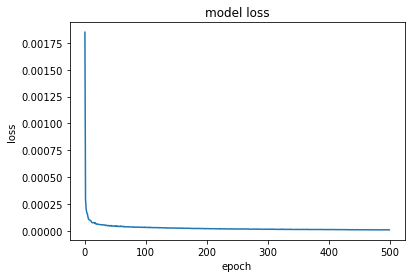

In [12]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

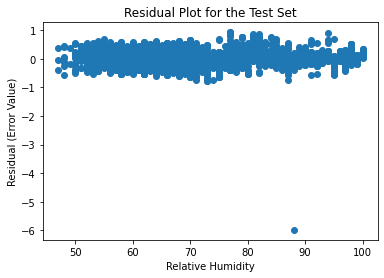

In [13]:
residual = y_test_unscaled - y_pred_unscaled
# sns.regplot(x = residual, y = y_test_unscaled, data = None, scatter = True, color = 'red')
plt.scatter(y_test_unscaled, residual)
plt.title("Residual Plot for the Test Set")
plt.xlabel("Relative Humidity")
plt.ylabel("Residual (Error Value)")
plt.show()

## The Predicted De Normalized and Un Sclaed Predictions and True Test target Values are shown together for Comparison

In [14]:
np.column_stack((y_test_unscaled,custom_scaler.inverseScaleY(y_pred)))

array([[78.        , 77.98710632],
       [78.        , 77.98132324],
       [81.        , 81.01409149],
       ...,
       [68.        , 68.48011017],
       [89.        , 88.98278046],
       [73.        , 72.97720337]])

# Here We Try and Test Our Model on Live Unseen Data Collected for the 21st OF December 2020

In [15]:
df_unseen = pd.read_csv("UnseenTest.csv")

In [16]:
df_unseen.head()

,ID,name,wmoID,time,pressure,windDir,windSpeed,windGust,temp,dewPoint,humidity,period,height,seaTemp,reportDate,reportTime,updated_At,created_at
0,444313,M5,62094,19 Dec 11:00,995.3,212,46,61,10.8,6.7,76,7.3,4.5,11.0,19-12-2020,11:00,2020-12-19 12:15:28,2020-12-19 12:15:28
1,444325,M5,62094,19 Dec 12:00,995.4,220,48,61,11.2,6.7,74,7.3,4.3,11.0,19-12-2020,12:00,2020-12-19 12:21:06,2020-12-19 12:21:06
2,444343,M5,62094,19 Dec 13:00,996.2,235,48,65,10.6,4.9,68,7.4,4.5,11.1,19-12-2020,13:00,2020-12-19 13:21:06,2020-12-19 13:21:06
3,444361,M5,62094,19 Dec 14:00,997.2,249,37,-,9.5,5.5,76,7.3,4.5,11.0,19-12-2020,14:00,2020-12-19 14:21:22,2020-12-19 14:21:22
4,444385,M5,62094,19 Dec 15:00,997.5,242,24,-,9.3,6.6,83,7.9,4.6,11.0,19-12-2020,15:00,2020-12-19 15:20:32,2020-12-19 15:20:32


In [17]:
x_unseen =df_unseen[["temp","dewPoint","seaTemp"]].values
y_unseen = df_unseen["humidity"].values

In [18]:
unseen_out = regression_model.predict((custom_scaler.scaleX(np.asarray(x_unseen).astype('float32'))))
unseen_out_unscaled = custom_scaler.inverseScaleY(unseen_out)
unseen_out_unscaled

1/1 [==============================] - 0s 2ms/step


array([75.95898 , 74.030334, 67.813225, 75.94275 , 82.96457 , 74.97683 ,
       77.00442 , 73.01387 , 70.99621 , 77.00284 , 75.951195, 74.94489 ,
       82.96411 , 74.03781 , 80.95692 , 80.96951 , 78.97483 , 76.97923 ,
       78.97483 , 74.94016 , 74.00923 , 77.984215, 78.958466, 70.897095,
       73.99957 , 72.006096], dtype=float32)

## Metrics for the new unseen data

In [19]:
print(mean_squared_error(unseen_out_unscaled, y_unseen))

0.0027569025920596547


In [20]:
from sklearn.metrics import r2_score
r2 = r2_score(unseen_out_unscaled, y_unseen)
adj_r2 = 1 - (1-r2)*(len(y_unseen)-1)/(len(y_unseen)-x_unseen.shape[1]-1)

In [21]:
r2

0.9997901210164142

In [22]:
adj_r2

0.9997615011550162

In [23]:
from sklearn.metrics import max_error
max_error(unseen_out_unscaled, y_unseen)

0.18677520751953125

In [24]:
residuals = y_unseen - unseen_out_unscaled

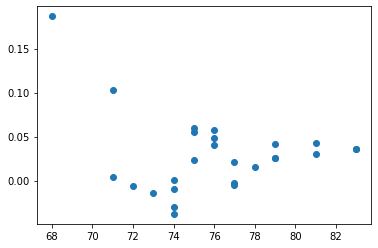

In [25]:
residuals.shape
plt.scatter(y_unseen, residuals)

plt.show()

## Comparing the Predictions vs the Unseen Data Values

In [26]:
np.column_stack((y_unseen, unseen_out_unscaled))

array([[76.        , 75.95897675],
       [74.        , 74.03033447],
       [68.        , 67.81322479],
       [76.        , 75.94274902],
       [83.        , 82.96456909],
       [75.        , 74.97682953],
       [77.        , 77.00441742],
       [73.        , 73.01387024],
       [71.        , 70.99620819],
       [77.        , 77.00283813],
       [76.        , 75.95119476],
       [75.        , 74.94489288],
       [83.        , 82.96411133],
       [74.        , 74.03781128],
       [81.        , 80.95691681],
       [81.        , 80.96951294],
       [79.        , 78.97483063],
       [77.        , 76.97923279],
       [79.        , 78.97483063],
       [75.        , 74.94016266],
       [74.        , 74.00923157],
       [78.        , 77.98421478],
       [79.        , 78.95846558],
       [71.        , 70.89709473],
       [74.        , 73.99957275],
       [72.        , 72.00609589]])